Задача построить простую модель для задачи **Image Captioning** - по изображению (image) сгенерировать текстовый заголовок (caption)

**Концепция простой модели**
- Будем рассматривать задачу предсказания следующего слова в предложении, имея изображение и предыдущие слова
- Для получения фичей из изображений будем использовать крупную свёрточную предобученную архитектуру
- Для получения фичей из предыдущего текста будем использовать рекуррентную архитектуру с предобученными эмбеддингами
- Сконкатенируем фичи по изображению и по тексту, чтобы получить финальный набор фичей
- Классификатор, завершающийся линейным слоем к размеру словаря над финальным набором фичей
- LogSoftmax + NLLLoss для оценки предсказания

## 0. Скачиваем и распаковываем данные

In [1]:
#!g1.1
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/b84AkmdsYEpWNg' 

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('dataset.tar.gz', 'wb') as f:  
    f.write(download_response.content)

## 1. Подготовка данных

In [2]:
#!g1.1:bash
!ls -sh dataset.tar.gz

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [3]:
!tar xf dataset.tar.gz -C .

In [6]:
!pip install opencv-python

In [7]:
#!g1.1
import cv2
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#!g1.1
# Смотрим на датасет с надписями к картинкам
data_folder = "./data/data"

dfs = dict()
for split in ['train', 'val']:
    dfs[split] = pd.read_csv(os.path.join(data_folder, f'captions_{split}.tsv'), sep='\t')

dfs['train'].head()

img_id                                         caption #0  \
0  0000.png  A child in a pink dress is climbing up a set o...   
1  0001.png         A black dog and a spotted dog are fighting   
2  0002.png  A little girl covered in paint sits in front o...   
3  0003.png  A man lays on a bench while his dog sits by him .   
4  0004.png     A man in an orange hat starring at something .   

                                          caption #1  \
0              A girl going into a wooden building .   
1  A black dog and a tri-colored dog playing with...   
2  A little girl is sitting in front of a large p...   
3  A man lays on the bench to which a white dog i...   
4            A man wears an orange hat and glasses .   

                                          caption #2  \
0   A little girl climbing into a wooden playhouse .   
1  A black dog and a white dog with brown spots a...   
2  A small girl in the grass plays with fingerpai...   
3  a man sleeping on a bench outside with a white...   
4  A man with gauges and glasses is wearing a Bli...   

                                          caption #3  \
0  A little girl climbing the stairs to her playh...   
1  Two dogs of different breeds looking at each o...   
2  There is a girl with pigtails sitting in front...   
3  A shirtless man lies on a park bench with his ...   
4  A man with glasses is wearing a beer can croch...   

                                          caption #4  
0  A little girl in a pink dress going into a woo...  
1    Two dogs on pavement moving toward each other .  
2  Young girl with pigtails painting outside in t...  
3  man laying on bench holding leash of dog sitti...  
4  The man with pierced ears is wearing glasses a...

In [9]:
#!g1.1
dfs['train'].shape

(6000, 6)

In [10]:
#!g1.1
dfs['val'].shape

(1000, 6)

<class 'numpy.ndarray'>
(375, 500, 3)


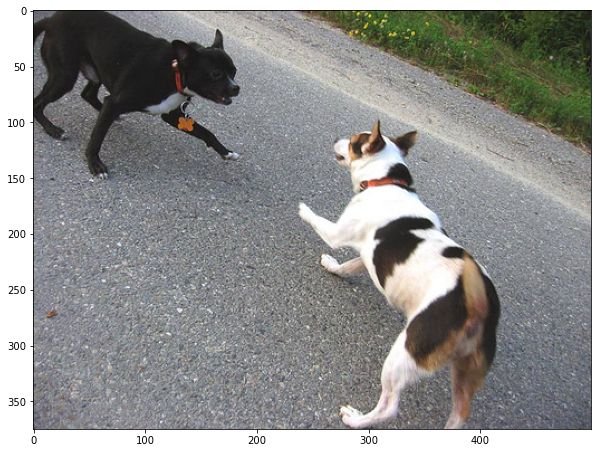

In [11]:
#!g1.1
# Пример картинки
fig, ax = plt.subplots(figsize=(10,8))
# Для чтения изображений из файлов мы будем использовать библиотеку cv2
image = cv2.imread(os.path.join(data_folder, 'train', '0001.png'))
print(type(image))
print(image.shape)
plt.imshow(image)
plt.show()

In [12]:
image # Что из себя представляет картинка

array([[[102, 103, 108],
        [ 95,  96, 101],
        [ 99, 100, 105],
        ...,
        [ 29,  29,  21],
        [ 31,  28,  23],
        [ 30,  25,  22]],

       [[108, 109, 114],
        [100, 101, 106],
        [ 94,  95, 100],
        ...,
        [ 37,  37,  29],
        [ 37,  34,  29],
        [ 33,  28,  25]],

       [[112, 112, 120],
        [118, 118, 126],
        [100, 100, 108],
        ...,
        [ 40,  40,  32],
        [ 37,  34,  29],
        [ 34,  31,  26]],

       ...,

       [[103, 101, 114],
        [104,  98, 110],
        [122, 114, 127],
        ...,
        [ 83,  88,  94],
        [ 76,  83,  89],
        [ 72,  79,  85]],

       [[111, 114, 121],
        [ 91,  88,  97],
        [ 85,  78,  86],
        ...,
        [ 95, 100, 106],
        [ 79,  84,  90],
        [ 79,  84,  90]],

       [[ 93,  96, 101],
        [ 69,  66,  73],
        [111, 101, 109],
        ...,
        [ 88,  91,  98],
        [ 82,  85,  92],
        [ 94,  99, 105]]

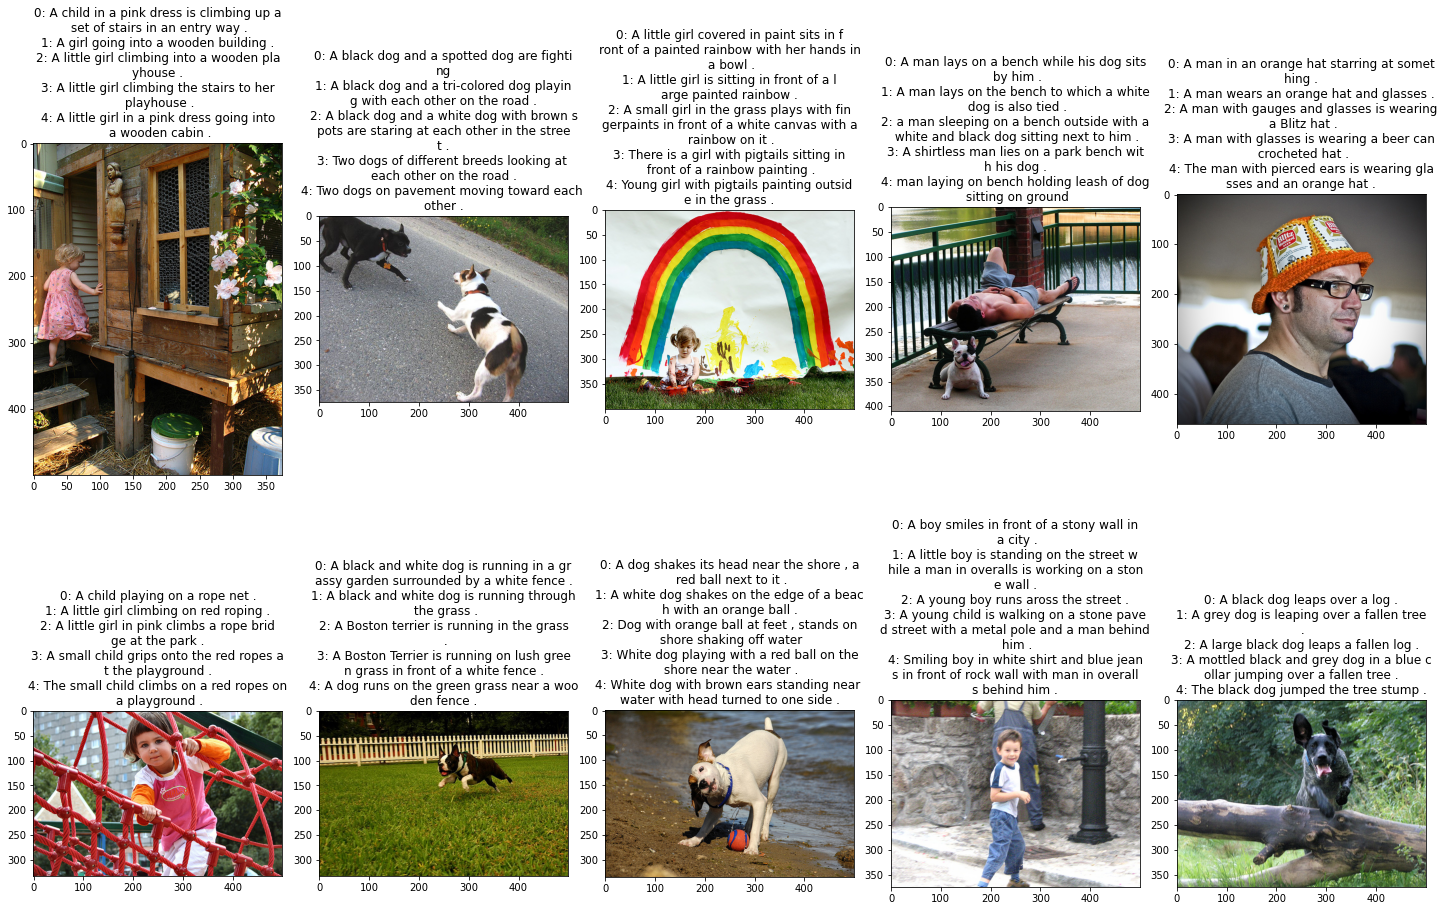

In [13]:
#!g1.1
# Смотрим на примеры картинок и подписей к нем
inds = list(range(10))
split = 'train'

h, w = 2, 5
title_width = 43

assert h*w >= len(inds)

fig, ax = plt.subplots(h, w, figsize=(20, 15))

for i, ind in enumerate(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    captions = [row[f'caption #{i}'] for i in range(5)]
    
    caption_adjasted = map(lambda el: '\n'.join([(str(el[0]) + ': ' + el[1])[k:k+title_width] for k in range(0, 3 + len(el[1]), title_width)]), enumerate(captions))
    caption = '\n'.join(caption_adjasted)
    plt.subplot(h, w, i+1)
    plt.title(caption)
    plt.imshow(cv2.imread(os.path.join(data_folder, split, img_id)))

fig.tight_layout()
plt.show()

### 1.2 Предобработка изображений

**Сперва напишем предобработку для изображений**

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
#!g1.1
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tr

In [15]:
#!g1.1
# Посчитаем поканальные mean и std для всех изображений из train
# Потом это понадобится в трансформе

inds = list(range(dfs['train'].shape[0]))
split = 'train'

channel_mean = np.zeros(3)
channel_std = np.zeros(3)

for ind in tqdm(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    img = cv2.imread(os.path.join(data_folder, 'train', img_id))
    img = np.array(img) / 255
    channel_mean += img.mean(axis=(0, 1))
    channel_std += img.std(axis=(0, 1))

channel_mean /= len(inds)
channel_std /= len(inds)

print(channel_mean, channel_std)

  0%|          | 0/6000 [00:00<?, ?it/s]

[0.45802264 0.44634529 0.40322752] [0.24192556 0.23314284 0.23692942]


In [16]:
import PIL

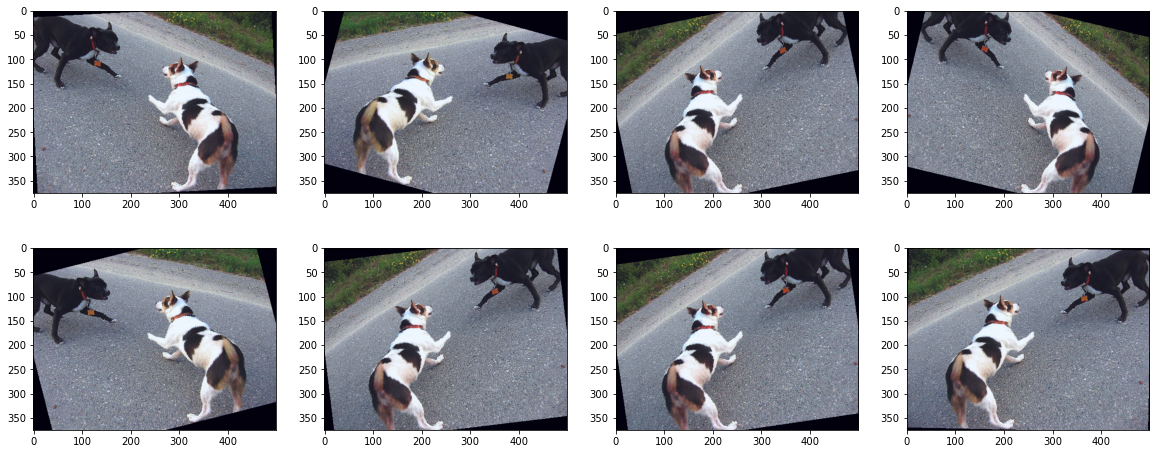

In [17]:
#!g1.1
# Напишем функцию для предобработки одного изображения
# Здесь пока не привожу к одному размеру, но потом буду, так как резнет обучался на Image Net, в котором картинки 224 х 224

image_prepare = tr.Compose([
    tr.ToPILImage(), 
    tr.ColorJitter(hue=.05, saturation=.05),  
    tr.RandomHorizontalFlip(0.5),
    tr.RandomRotation(20),
    tr.ToTensor(),
    tr.Normalize(channel_mean, channel_std) # Передаем посчитанные до этого значения
])

# Sanity check
from sklearn.preprocessing import minmax_scale

image = cv2.imread(os.path.join(data_folder, "train", "0001.png"))

def de_normalize(img):
    return minmax_scale(
        (img.reshape(3, -1) + channel_mean[:, None]) * channel_std[:, None],
        axis=1,
    ).reshape(*img.shape)


# Смотрим что произошло с картинкой
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    transformed_image = image_prepare(image).numpy().transpose(1, 2, 0)
    plt.imshow(de_normalize(transformed_image))
plt.show()

### 1.3 Предобработка заголовков

**Затем напишем предобработку для заголовков**

Для простоты вычислений предлагаю сделать крайне простую токенизацию, пользуясь регулярными выражениями и библиотекой **re**

1. Приводим текст к нижнему регистру
2. Заменяем всю пунктуацию на пробелы
3. Убираем пробельные символы с концов строки
4. Разбиваем по ненулевой последовательности пробельных символов
5. Добавляем специальные токены \<BOS> (begin of sentence) и \<EOS> (end of sentence), чтобы обозначить границы заголовка для модели

In [19]:
#!g1.1
import re

def tokenize(text):
    text = text.lower() # 1
    text = re.sub('\W+\s*', ' ', text) # 2
    text = text.rstrip() # 3
    text += ' <EOS>' # 5
    text = '<BOS> ' + text
    tokens = text.split() # 4
    return tokens

In [135]:
# Пример работы
text = 'GGAcvacv,  ty , dg ld! lkd - lfd * sf_id  '
tokenize(text)

['<BOS>', 'ggacvacv', 'ty', 'dg', 'ld', 'lkd', 'lfd', 'sf_id', '<EOS>']

Соберём словарь из всех слов, что встречаются в заголовках в train
1. Токенизируем заголовки
2. Обновляем частоту всех отдельных токенов
3. Выкидываем все слова с частотой не больше минимума (допустим 3 - можете взять другое число) -> заменяем на специальный \<UNK> (unknown) токен
4. Записываем быстрое преобразование из токенов в индексы и наоборот

In [20]:
dfs['val'].head() # смотрим на датасет до

img_id                                         caption #0  \
0  6000.png  A child and a woman are at waters edge in a bi...   
1  6001.png  A boy with a stick kneeling in front of a goal...   
2  6002.png      A woman crouches near three dogs in a field .   
3  6003.png  A boy bites hard into a treat while he sits ou...   
4  6004.png  A person eats takeout while watching a small t...   

                                          caption #1  \
0  a large lake with a lone duck swimming in it w...   
1  A child in a red jacket playing street hockey ...   
2  Three dogs are playing on grassy hill with a b...   
3                 A child biting into a baked good .   
4  A person sits on the floor and eats in front o...   

                                          caption #2  \
0           A little boy at a lake watching a duck .   
1  A young kid playing the goalie in a hockey rink .   
2  Three dogs are standing in the grass and a per...   
3  A small boy putting something in his mouth wit...   
4      A television with a picture of a girl on it .   

                                          caption #3  \
0  A young boy waves his hand at the duck in the ...   
1  A young male kneeling in front of a hockey goa...   
2                        Three dogs on a grassy hill   
3       The boy eats his food outside at the table .   
4  A young man sits on the floor by the televisio...   

                                          caption #4  
0  Two people are at the edge of a lake , facing ...  
1  Hockey goalie boy in red jacket crouches by go...  
2  Three dogs stand in a grassy field while a per...  
3          The boy is eating pizza over a tin dish .  
4  Someone is laying in front of the TV eating fo...

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

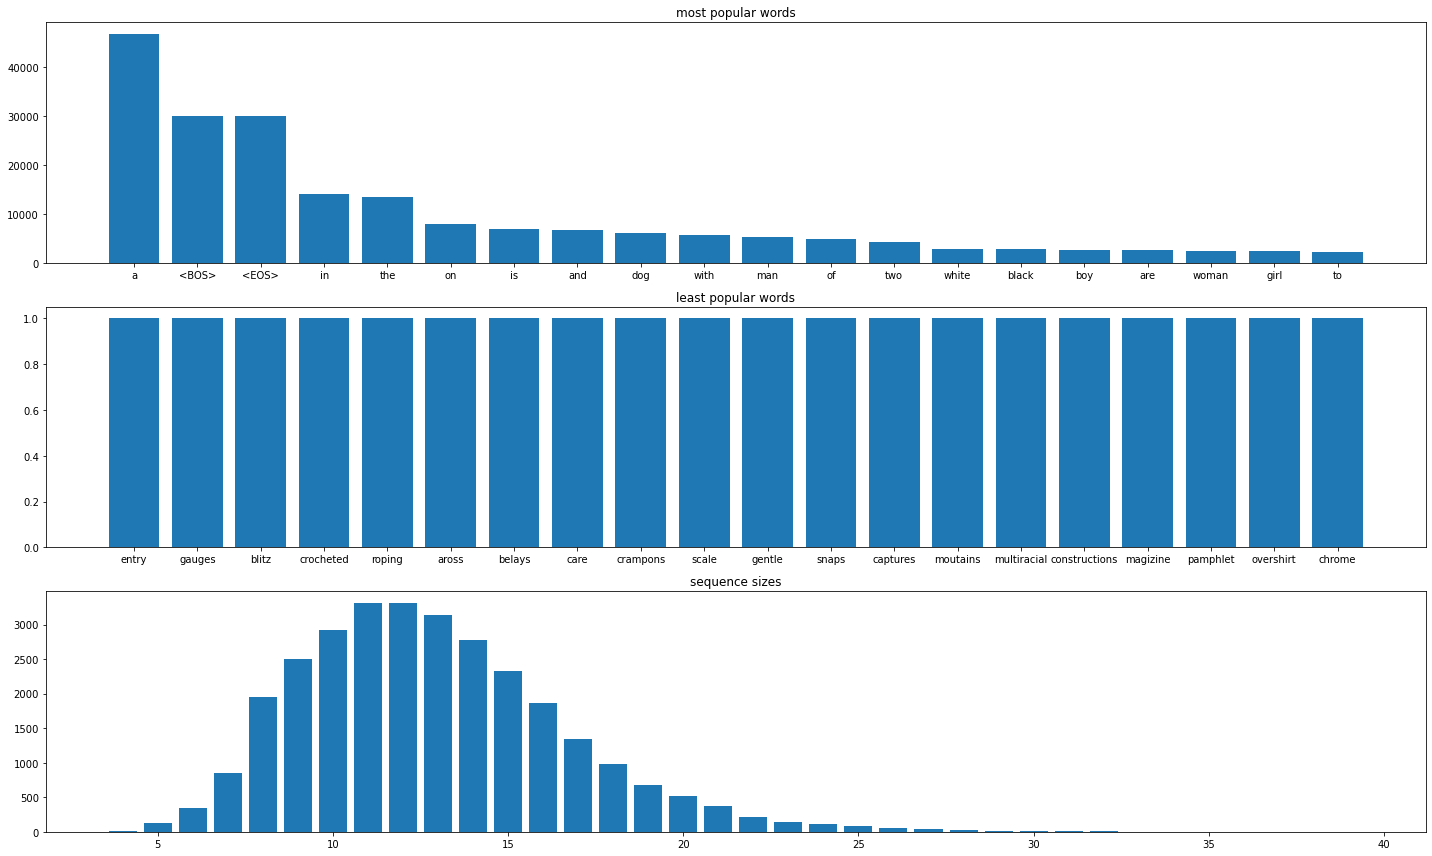

In [21]:
#!g1.1
from tqdm.notebook import trange
from collections import Counter

vocab_freq = Counter()

# Параллельно заодно посчитаем длины заголовков в токенах (сколько раз встречалась какая длина в токенах) 
# так же здесь можно использовать val при желании
# Заполняем vocab_freq
sizes = Counter()
for i in trange(len(dfs['train'])):
    row = dfs['train'].iloc[i]
    captions = [row[f'caption #{j}'] for j in range(5)]
    tokenized_cap = [tokenize(captions[j]) for j in range(5)]
    for j in range(5):
      sizes[len(tokenized_cap[j])] += 1
    for j in range(5):
      for k in range(len(tokenized_cap[j])):
        vocab_freq[tokenized_cap[j][k]] += 1  

# Преобразовываем наши датасеты
for split in ['train', 'val']:
  for i in trange(len(dfs[split])):
    row = dfs[split].iloc[i]
    captions = [row[f'caption #{j}'] for j in range(5)]
    tokenized_cap = [tokenize(captions[j]) for j in range(5)]
    for j in range(5):
      for k in range(len(tokenized_cap[j])):
        if vocab_freq[tokenized_cap[j][k]] <= 3: # Заменяем редко встречающиеся слова на unknown
          tokenized_cap[j][k] = '<UNK>' 
    for j in range(5):
      dfs[split].iloc[i][f'caption #{j}'] = tokenized_cap[j]

max_seq_len = np.max(list(sizes.keys()))

show_ = 20
fig, ax = plt.subplots(3, 1, figsize=(20, 12))

plt.subplot(312)
vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1])}
plt.title('least popular words')
plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

plt.subplot(311)
vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1], reverse=True)}
plt.title('most popular words')
plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

plt.subplot(313)
plt.title('sequence sizes')
plt.bar(list(sizes.keys()), list(sizes.values()))

fig.tight_layout()
plt.show()

In [22]:
dfs['val'].head() # теперь посмотрим что стало после токенизации

img_id                                         caption #0  \
0  6000.png  [<BOS>, a, child, and, a, woman, are, at, wate...   
1  6001.png  [<BOS>, a, boy, with, a, stick, kneeling, in, ...   
2  6002.png  [<BOS>, a, woman, crouches, near, three, dogs,...   
3  6003.png  [<BOS>, a, boy, bites, hard, into, a, treat, w...   
4  6004.png  [<BOS>, a, person, eats, <UNK>, while, watchin...   

                                          caption #1  \
0  [<BOS>, a, large, lake, with, a, lone, duck, s...   
1  [<BOS>, a, child, in, a, red, jacket, playing,...   
2  [<BOS>, three, dogs, are, playing, on, grassy,...   
3  [<BOS>, a, child, biting, into, a, <UNK>, good...   
4  [<BOS>, a, person, sits, on, the, floor, and, ...   

                                          caption #2  \
0  [<BOS>, a, little, boy, at, a, lake, watching,...   
1  [<BOS>, a, young, kid, playing, the, goalie, i...   
2  [<BOS>, three, dogs, are, standing, in, the, g...   
3  [<BOS>, a, small, boy, putting, something, in,...   
4  [<BOS>, a, <UNK>, with, a, picture, of, a, gir...   

                                          caption #3  \
0  [<BOS>, a, young, boy, waves, his, hand, at, t...   
1  [<BOS>, a, young, male, kneeling, in, front, o...   
2   [<BOS>, three, dogs, on, a, grassy, hill, <EOS>]   
3  [<BOS>, the, boy, eats, his, food, outside, at...   
4  [<BOS>, a, young, man, sits, on, the, floor, b...   

                                          caption #4  
0  [<BOS>, two, people, are, at, the, edge, of, a...  
1  [<BOS>, hockey, goalie, boy, in, red, jacket, ...  
2  [<BOS>, three, dogs, stand, in, a, grassy, fie...  
3  [<BOS>, the, boy, is, eating, pizza, over, a, ...  
4  [<BOS>, someone, is, laying, in, front, of, th...

In [21]:
max_seq_len

39

In [23]:
#!g1.1
# Так же добавляем <PAD> токен для паддингов
# Словари для быстрого кодирования / декодирования слов
tok_to_ind = {
    '<UNK>': 0,
    '<BOS>': 1,
    '<EOS>': 2,
    '<PAD>': 3,
}

ind_to_tok = {
    0: '<UNK>',
    1: '<BOS>',
    2: '<EOS>',
    3: '<PAD>',
}

ind = 4
for word in vocab_freq:
  if word != '<EOS>' and word != '<BOS>' and vocab_freq[word] > 3:
    tok_to_ind[word] = ind
    ind_to_tok[ind] = word
    ind += 1

assert len(tok_to_ind) == len(ind_to_tok)
vocab_size = len(tok_to_ind)
print(vocab_size)

2917


In [24]:
ind_to_tok[4], tok_to_ind['child'] # Проверяем, что все записалось

('a', 44)

In [25]:
#!g1.1
# Функция возвращает по тексту индексы токенов в тексте
def to_ids(text):
    text = tokenize(text)
    indices = []
    for word in text:
      if word in tok_to_ind:
        indices.append(tok_to_ind[word])
      else:
        indices.append(tok_to_ind['<UNK>'])
    return indices

In [26]:
#!g1.1
# Пример работы функции выше
text = "Some random text I wrote. And the one, that cann't be forgotten unless I'll decide that... Tho it's still great"
toks = tokenize(text)
ids = to_ids(text)
print(toks)
print(ids)
assert toks[0] == '<BOS>' and toks[-1] == '<EOS>'
assert ids[0] == tok_to_ind['<BOS>'] and ids[-1] == tok_to_ind['<EOS>']

['<BOS>', 'some', 'random', 'text', 'i', 'wrote', 'and', 'the', 'one', 'that', 'cann', 't', 'be', 'forgotten', 'unless', 'i', 'll', 'decide', 'that', 'tho', 'it', 's', 'still', 'great', '<EOS>']
[1, 104, 0, 0, 1372, 0, 9, 6, 60, 153, 0, 266, 498, 0, 0, 1372, 0, 0, 153, 0, 157, 158, 1540, 2469, 2]


### 1.4 Датасет

**Сделаем класс датасета в стиле torch.utils.data.Dataset**

In [48]:
#!g1.1
import torch

class ImageCaptioningDataset(Dataset):
    """
        imgs_path ~ путь к папке с изображениями
        captions_path ~ путь к .tsv файлу с заголовками изображений
    """
    def __init__(self, imgs_path, captions_path):
        super(ImageCaptioningDataset).__init__()
        # Читаем и записываем из файлов в память класса, чтобы быстро обращаться внутри датасета
        self.data = pd.read_csv(captions_path, sep='\t')
        # Загружаем все картинки и делаем аугментацию. Тут уже приводим все картинки к едином размеру 224 * 224, так как 
        # резнет работает с картинками такого размера изначально (обучался на Image Net, где у картинок такой размер)
        self.imgs = []
        image_prepare = tr.Compose([
                                    tr.ToPILImage(),
                                    tr.Resize((224, 224)),
                                    tr.ColorJitter(hue=.05, saturation=.05),  
                                    tr.RandomHorizontalFlip(0.5),
                                    tr.RandomRotation(20),
                                    tr.ToTensor(),
                                    tr.Normalize(channel_mean, channel_std)
                                ])
        for index in range(len(self.data)):
            row = self.data.iloc[index]
            img_id = row['img_id']
            img = cv2.imread(os.path.join(imgs_path, img_id))
            img = image_prepare(img)
            self.imgs.append(img)

        # Предобработка текста (то же самое уже делали)
        for i in trange(len(self.data)):
          row = self.data.iloc[i]
          captions = [row[f'caption #{j}'] for j in range(5)]
          tokenized_cap = [tokenize(captions[j]) for j in range(5)]
          for j in range(5):
            for k in range(len(tokenized_cap[j])):
              if tokenized_cap[j][k] not in vocab_freq or vocab_freq[tokenized_cap[j][k]] <= 3:
                tokenized_cap[j][k] = '<UNK>' 
          for j in range(5):
            self.data.iloc[i][f'caption #{j}'] = [tok_to_ind[tokenized_cap[j][l]] for l in range(len(tokenized_cap[j]))]

    def __getitem__(self, index):
        
        # Получаем предобработанное изображение
        img = self.imgs[index]
        
        # Получаем по каждому заголовку набор in текстов - out слов
        #   в каждом заголовке берём всевозможные не пустые префиксы как in и следующее за префиксом слово как out
        #   применяем padding ко всем текстам в in --- слева
        #   in_seqs: torch.tensor \in [\sum{len(caption_i) - 1}; max_seq_len or local_max_seq_len]
        #   out_words: torch.tensor \in [\sum{len(caption_i) - 1}]
        row = self.data.iloc[index]
        captions = [row[f'caption #{j}'] for j in range(5)]
        lens = [len(captions[i]) for i in range(5)]
        in_seqs = torch.zeros((sum(lens) - 5, max_seq_len)) + 3
        out_words = torch.zeros(sum(lens) - 5)

        n = 0
        for i in range(5):
          for j in range(len(captions[i]) - 1):
            for k in range(j + 1):
              in_seqs[n + j][max_seq_len + k - j - 1] = int(captions[i][k])
              out_words[n + j] = int(captions[i][k + 1])
          n += lens[i] - 1
        
        return img, torch.tensor(in_seqs, dtype = torch.int64), torch.tensor(out_words, dtype = torch.int64)
    
    def __len__(self):
        return len(self.data)

Обращу внимание, что я заппадил все слева, так как модель получает на вход последовательность длины max_seq_len = 39. Получается, слева у нас идут пропуски, а потом с какого-то момента начинается реальный текст, который мы хотим продолжить одним словом. Если бы мы паддили справа, то получалось бы немного странно, что мы сначала читаем начало, потом идет куча пропусков, а потом мы хотим эту кучу пропусков чем-то продолжить. Модель выучит тупо, что надо пропусками все продлевать, и будет радоваться жизни, а мы будем страдать.

In [49]:
#!g1.1
ds_train = ImageCaptioningDataset(os.path.join(data_folder, 'train'), os.path.join(data_folder, f'captions_train.tsv'))
ds_val = ImageCaptioningDataset(os.path.join(data_folder, 'val'), os.path.join(data_folder, f'captions_val.tsv'))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [50]:
#!g1.1
img_, in_seqs_, out_words_ = ds_train[0]

assert isinstance(img_, torch.Tensor)
assert isinstance(in_seqs_, torch.Tensor)
assert isinstance(out_words_, torch.Tensor)

assert img_.shape[0] == 3
assert in_seqs_.shape[0] == out_words_.shape[0]
assert ind_to_tok[out_words_[-1].item()] == "<EOS>"

assert ds_train.__len__() == len(os.listdir(os.path.join(data_folder, 'train')))
assert ds_val.__len__() == len(os.listdir(os.path.join(data_folder, 'val')))

print(img_.shape)
print(in_seqs_.shape)
print(out_words_.shape)

torch.Size([3, 224, 224])
torch.Size([58, 39])
torch.Size([58])


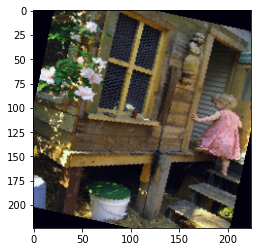

In [51]:
#!g1.1
# Sanity check
plt.imshow(
    de_normalize(img_.numpy().transpose(1, 2, 0))
)
plt.show()

In [52]:
# Вроде все как надо
for i in range(len(in_seqs_)): 
  print(in_seqs_[i, 20:].numpy())

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 4]
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  1  4 44]
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  1  4 44  5]
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  1  4 44  5  4]
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  1  4 44  5  4 89]
[  3   3   3   3   3   3   3   3   3   3   3   3   1   4  44   5   4  89
 173]
[  3   3   3   3   3   3   3   3   3   3   3   1   4  44   5   4  89 173
   8]
[  3   3   3   3   3   3   3   3   3   3   1   4  44   5   4  89 173   8
 118]
[  3   3   3   3   3   3   3   3   3   1   4  44   5   4  89 173   8 118
  54]
[  3   3   3   3   3   3   3   3   1   4  44   5   4  89 173   8 118  54
   4]
[  3   3   3   3   3   3   3   1   4  44   5   4  89 173   8 118  54   4
 391]
[  3   3   3   3   3   3   1   4  44   5   4  89 173   8 118  54   4 391
  13]
[  3   3   3   3   3   1   4  44   5   4  89 173   8 118  54   4 391  13
 398]
[  3   3   3   3   1   4  44   5   4  89 173   8 118

### 1.5 Даталоадер

In [53]:
#!g1.1
# Сложим батч в следующем виде:
#   img_batch: [bs, c, h, w]
#   in_seqs_batch: [\sum_{i \in range(bs)}(\sum(seq_lens)_i), max_seq_len or local_max_seq_len]
#   out_words_batch: [\sum_{i \in range(bs)}(\sum(seq_lens)_i)]
#   text_to_image_align: [bs] --> число строк в in_seqs_batch и out_seqs_batch, соответствующих картинке

def collate_fn(batch):
    img_batch = [batch[i][0].tolist() for i in range(len(batch))]
    text_to_image_align = torch.tensor([len(batch[i][2]) for i in range(len(batch))], dtype=torch.int64)
    in_seqs_batch = []
    out_words_batch = []
    for i in range(len(batch)):
        in_seqs_batch.extend(batch[i][1].tolist())
        out_words_batch.extend(batch[i][2].tolist())
    return torch.tensor(img_batch), torch.tensor(in_seqs_batch, dtype=torch.int64), torch.tensor(out_words_batch, dtype=torch.int64), text_to_image_align

In [54]:
#!g1.1
batch_size = 32

dataloader_train = DataLoader(
    dataset=ds_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

dataloader_val = DataLoader(
    dataset=ds_val,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
)

In [55]:
#!g1.1

img_batch, in_seqs_batch, out_words_batch, text_to_image_align = next(iter(dataloader_train))

assert isinstance(img_batch, torch.Tensor)
assert isinstance(in_seqs_batch, torch.Tensor)
assert isinstance(out_words_batch, torch.Tensor)
assert isinstance(text_to_image_align, torch.Tensor)

assert img_batch.shape[:2] == torch.Size([batch_size, 3])
assert in_seqs_batch.shape[0] == out_words_batch.shape[0]
assert text_to_image_align.shape[0] == batch_size
assert text_to_image_align.sum() == in_seqs_batch.shape[0]

assert in_seqs_batch.dtype in {torch.int64, torch.LongTensor}
assert out_words_batch.dtype in {torch.int64, torch.LongTensor}
assert text_to_image_align.dtype in {torch.int64, torch.LongTensor}

print(img_batch.shape, in_seqs_batch.shape, out_words_batch.shape, text_to_image_align.shape, sep="\n")

torch.Size([32, 3, 224, 224])
torch.Size([1868, 39])
torch.Size([1868])
torch.Size([32])


## 2. Составляем модель

### 2.1 Фича-экстрактор для изображений

In [37]:
#!g1.1
from torchvision import models
from torch import nn

In [38]:
from torchvision.models import resnet18

resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))

Using cpu device


In [40]:
#!g1.1
class img_fe_class(nn.Module):
    def __init__(self):
        super(img_fe_class, self).__init__()
        model = resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False  # Freezing all layers
        model.fc = nn.Linear(model.fc.in_features, model.fc.in_features) # сделаем 512 фич на выходе
        self.img_fe = model
        
    def forward(self, imgs):
        imgs.to(device)
        return self.img_fe(imgs)

In [41]:
#!g1.1
img_fe = img_fe_class()
    
feat_img = img_fe(img_[None,:,:,:])

assert len(feat_img.shape) == 2
assert feat_img.shape[0] == 1

print(f'outputs {feat_img.shape[1]} features from feature extractor')

outputs 512 features from feature extractor


### 2.2 Фича-экстрактор для текста

Давайте скачаем предобученные glove вектора и инициализируем nn.Embedding ими, там где мы их знаем

In [81]:
#!g1.1:bash
# !wget -O glove.zip https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip

# mirror https://nlp.stanford.edu/data/wordvecs/glove.840B.300d.zip

In [82]:
#!g1.1:bash
# !unzip glove.zip

In [83]:
#!g1.1:bash
# !ls -sh glove.* 

In [ ]:
# Закомментил все, так как скачал glove себе локально, но можно пользоваться и тем, что выше

In [80]:
#!g1.1
# Открываем glove
np.random.seed(19)

def load_glove_weights(file_path, vocab, pad_token="<PAD>"):
    print("Loading Glove Weights")
    # Инициализируем веса для всех слов стандартным нормальным распределением
    glove_weights = np.random.uniform(0, 1, (len(vocab), 300))
    mask_found = np.zeros(len(vocab), dtype=bool)
    
    with open(file_path, 'r', encoding="utf8") as f:
        for line in tqdm(f, total=2196018):
            line = line.split()
            token = ' '.join(line[:-300])
            embed = line[-300:]

            if token in vocab:
                ind = vocab[token]
                mask_found[ind] = True
                glove_weights[ind, :] = np.array(list(map(float, embed)), dtype=np.float)

    print(f"{mask_found.sum()} words from vocab of size {len(vocab)} loaded!")

    glove_weights[vocab[pad_token]] = np.zeros(300, dtype=np.float)
    return glove_weights, mask_found


glove_path = "glove.840B.300d/glove.840B.300d.txt"
glove_weights, mask_found = load_glove_weights(glove_path, tok_to_ind, "<PAD>")

Loading Glove Weights


  0%|          | 0/2196018 [00:00<?, ?it/s]

2911 words from vocab of size 2917 loaded!


In [84]:
#!g1.1
class text_fe_class(nn.Module):
    def __init__(self):
        super(text_fe_class, self).__init__()
        self.embed = nn.Embedding(num_embeddings=len(tok_to_ind), embedding_dim=300)
        self.embed.weight = nn.Parameter(
                torch.from_numpy(glove_weights),
                requires_grad = False,
            )
        
        hidden_size=100
        D = 2
        output_size = 512

        self.rnn_layers = nn.RNN(
            input_size=300,
            hidden_size=hidden_size,
            num_layers=4,
            bidirectional=True,
            dropout=0.3,
            batch_first=True,
        )
        
        self.to_class = nn.Linear(hidden_size * D, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, in_seqs):
        in_seqs = self.embed(in_seqs)
        output, hn = self.rnn_layers(torch.tensor(in_seqs.detach(), dtype=torch.float32))
            
        # output ~ batch_size x seq_len x hidden_size * 2
        # reduce чтобы уйти от seq_len
        self.reduce = 'mean'
        
        if self.reduce == 'last':
            output = output[:, -1, :]
        elif self.reduce == 'mean':
            output = output.mean(1) # вдоль dim = 1
        elif self.reduce == 'max':
            output = output.max(1)
        elif self.reduce == 'sum':
            output = output.sum(1)
        
        return self.logsoftmax(self.to_class(output))

In [85]:
#!g1.1
text_fe = text_fe_class()
feat_text = text_fe(in_seqs_)

assert in_seqs_.shape[0] == feat_text.shape[0]
assert len(feat_text.shape) == 2 # 'По каждому тексту вам нужен один вектор, а RNN блок возвращает output для каждого шага seq_len, не забудьте как-то это исправить'

print(in_seqs_.shape)
print(feat_text.shape)

torch.Size([58, 39])
torch.Size([58, 512])


### 2.3 Финальная модель

Сконкатенируем полученные фичи и подаем в линейный слой

In [116]:
#!g1.1
from collections import OrderedDict

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

class image_captioning_model(nn.Module):
    def __init__(self, img_fe, text_fe, hid_size = 1024, dropout_p = 0.3, device=device):
        super(image_captioning_model, self).__init__()
        self.image_fe = img_fe
        self.text_fe = text_fe
        self.device = device
        
        self.fc = nn.Sequential(OrderedDict([
            ('in2hid', nn.Linear(1024, hid_size)),
            ('act', nn.ReLU()),
            ('drop', nn.Dropout(dropout_p)),
            ('bnorm', nn.BatchNorm1d(hid_size)),
            ('hid2out', nn.Linear(hid_size, vocab_size)),
            ('log_soft', nn.LogSoftmax(dim=-1)),
        ]))
        
    def forward(self, img_batch, in_seqs_batch, text_to_image_align):
        img_batch = img_batch.to(device)
        in_seqs_batch = in_seqs_batch.to(device)
        text_to_image_align = text_to_image_align.to(device)
        img_feat = self.image_fe(img_batch)
        seq_feat = self.text_fe(in_seqs_batch)
        img_feat = torch.repeat_interleave(img_feat, text_to_image_align, dim = 0)
        return self.fc(torch.concat((img_feat, seq_feat), dim = 1))

In [117]:
#!g1.1
model = image_captioning_model(img_fe, text_fe).float().to(device)

res = model(img_batch, in_seqs_batch, text_to_image_align)

assert res.shape[0] == np.sum(out_words_batch.shape[0])
assert res.shape[1] == vocab_size

print(res.shape)

torch.Size([1868, 2917])


In [118]:
#!g1.1
from termcolor import colored

def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))

# Считаем общее число параметров в нашей модели
def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    for param in model.named_parameters():
        num_params = np.prod(param[1].shape)
        if verbose_all or (verbose_only_learnable and param[1].requires_grad):
            print(
                colored(
                    '{: <42} ~  {: <9} params ~ grad: {}'.format(
                        param[0],
                        beautiful_int(num_params),
                        param[1].requires_grad,
                    ),
                    {True: "green", False: "red"}[param[1].requires_grad],
                )
            )
        sum_params += num_params
        if param[1].requires_grad:
            sum_learnable_params += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )
    return sum_params, sum_learnable_params


sum_params, sum_learnable_params = model_num_params(model)

image_fe.img_fe.conv1.weight               ~  9.408     params ~ grad: False
image_fe.img_fe.bn1.weight                 ~  64        params ~ grad: False
image_fe.img_fe.bn1.bias                   ~  64        params ~ grad: False
image_fe.img_fe.layer1.0.conv1.weight      ~  36.864    params ~ grad: False
image_fe.img_fe.layer1.0.bn1.weight        ~  64        params ~ grad: False
image_fe.img_fe.layer1.0.bn1.bias          ~  64        params ~ grad: False
image_fe.img_fe.layer1.0.conv2.weight      ~  36.864    params ~ grad: False
image_fe.img_fe.layer1.0.bn2.weight        ~  64        params ~ grad: False
image_fe.img_fe.layer1.0.bn2.bias          ~  64        params ~ grad: False
image_fe.img_fe.layer1.1.conv1.weight      ~  36.864    params ~ grad: False
image_fe.img_fe.layer1.1.bn1.weight        ~  64        params ~ grad: False
image_fe.img_fe.layer1.1.bn1.bias          ~  64        params ~ grad: False
image_fe.img_fe.layer1.1.conv2.weight      ~  36.864    params ~ grad: False

## 3. Пайплайн обучения

### 3.1 Оптимайзер

In [120]:
#!g1.1
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-3, beta1=0.9, beta2=0.999, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr, [beta1, beta2])
    return model, optimizer

model_params = {
    'img_fe': img_fe_class,
    'text_fe': text_fe_class,
    'hid_size': 1024,
    'dropout_p': 0.3,
}

model, optimizer = create_model_and_optimizer(
    model_class = image_captioning_model, 
    model_params = model_params,
    lr = 1e-3,
)

### 3.2 Один шаг обучения/валидации

In [121]:
#!g1.1
from collections import defaultdict

def train(model, opt, loader, criterion):
    model.train()
    losses_tr = []
    for img_batch, in_seqs_batch, out_words_batch, text_to_image_align in tqdm(loader):
        optimizer.zero_grad()

        img_batch.to(device)
        in_seqs_batch.to(device)
        text_to_image_align.to(device)

        pred = model(img_batch, in_seqs_batch, text_to_image_align)
        pred.to(device)
        out_words_batch.to(device)
        loss = criterion(pred, out_words_batch.to(device))
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return model, optimizer, np.mean(losses_tr)


def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    if metric_names is not None:
        metrics = defaultdict(list)
    with torch.no_grad():
        for img_batch, in_seqs_batch, out_words_batch, text_to_image_align in tqdm(loader):
            img_batch.to(device)
            in_seqs_batch.to(device)
            text_to_image_align.to(device)

            pred = model(img_batch, in_seqs_batch, text_to_image_align)
            pred.to(device)
            out_words_batch.to(device)
            loss = criterion(pred, out_words_batch.to(device))

            losses_val.append(loss.item())
            
            # Можете добавить сюда любые метрики, которые хочется (см. код здесь и 3.3 за подробностями)
            if metric_names is not None:
                if 'accuracy' in metric_names:
                    preds = torch.argsort(pred, dim=1, descending=True)
                    for k in metric_names["accuracy"]["top"]:
                        metrics[f'accuracy ~ top#{k}'].append(
                            np.mean([out_words_batch[i].item() in preds[i, :k] for i in range(out_words_batch.shape[0])])
                        )

        if metric_names is not None:
            for name in metrics:
                metrics[name] = np.mean(metrics[name])
    
    return np.mean(losses_val), metrics if metric_names else None

### 3.3 Цикл обучения

In [122]:
#!g1.1
from IPython.display import clear_output
import warnings

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkp",
    metric_names=None,
    save_only_best=True,
):
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    
    if os.path.exists(os.path.join(chkp_folder, model_name)):
        model_name = model_name + "_v2"
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    os.makedirs(os.path.join(chkp_folder, model_name))
    
    losses = {'train': [], 'val': []}
    lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        lrs.append(get_lr(optimizer))
        
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names=metric_names)
            losses['val'].append(loss)
            if metrics_ is not None:
                for name, value in metrics_.items():
                    metrics[name].append(value)
            
            # Сохраняем лучшую по валидации модель
            if ((not save_only_best) or (loss < best_val_loss)):
                if not os.path.exists(chkp_folder):
                    os.makedirs(chkp_folder)
                torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'losses': losses,
                    },
                    os.path.join('./chkp', model_name, f'{model_name}#{epoch}.pt'),
                )
                best_val_loss = loss
            
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if separate_show else 2
            ww_metrics = 0
            if metric_names is not None:
                plot_ids_ = [
                    [key, metric_meta.get("plot id", 1)]
                    for key, metric_meta
                    in metric_names.items()
                ]
                ww_metrics = len(set(el[1] for el in plot_ids_))
                assert all(el[1] <= ww_metrics for el in plot_ids_)
                
                plot_ids = defaultdict(list)
                for el in plot_ids_:
                    plot_ids[el[1]].append(el[0])
                
            fig, ax = plt.subplots(1, ww + ww_metrics, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, ww + ww_metrics, 1)
            plt.plot(losses['train'], 'r.-', label='train')
            if separate_show:
                plt.title('loss on train')
                plt.legend()
            plt.grid()

            if separate_show:
                plt.subplot(1, ww + ww_metrics, 2)
                plt.title('loss on validation')
                plt.grid()
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.subplot(1, ww + ww_metrics, ww)
            plt.title('learning rate')
            plt.plot(lrs, 'g.-', label='lr')
            plt.legend()
            plt.grid()
            
            if metric_names is not None:
                for plot_id, keys in plot_ids.items():
                    for key in keys:
                        plt.subplot(1, ww + ww_metrics, ww + plot_id)
                        plt.title(f'additional metrics #{plot_id}')
                        for name in metrics:
                            if key in name:
                                plt.plot(metrics[name], '.-', label=name)
                        plt.legend()
                        plt.grid()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

### 3.4 Обучаем модель

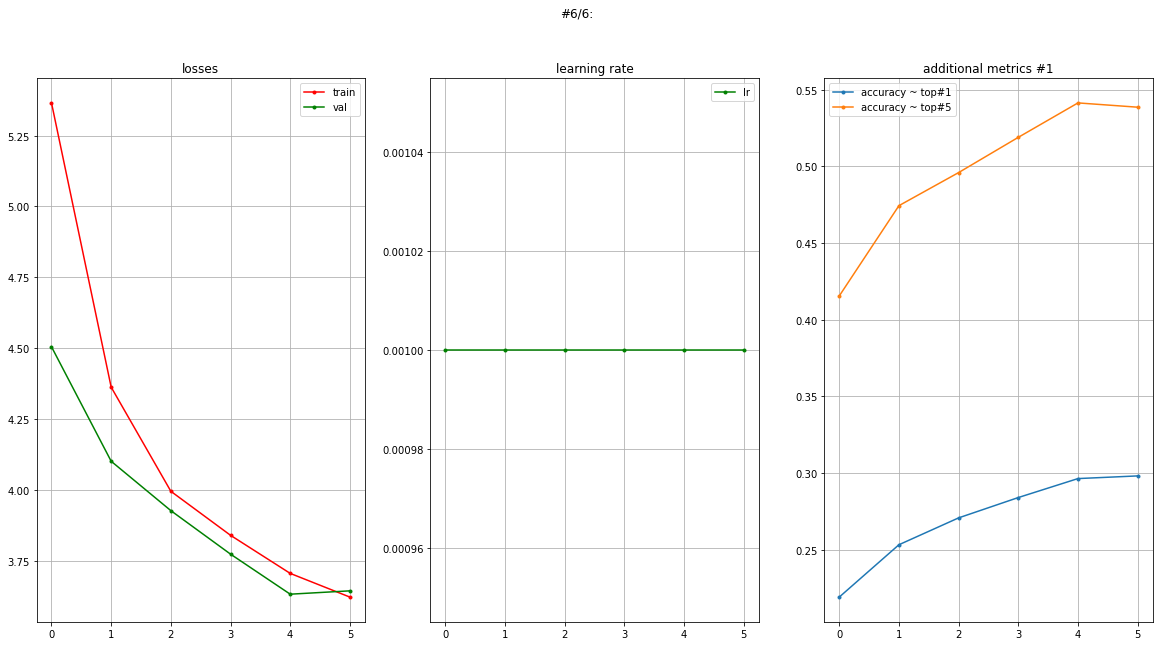

In [123]:
#!g1.1

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

img_fe = img_fe_class()
text_fe = text_fe_class()

model, optimizer = create_model_and_optimizer(
    model_class = image_captioning_model,
    model_params = {
        'img_fe': img_fe,
        'text_fe': text_fe,
        'hid_size': 1024,
        'dropout_p': 0.3,
    },
    lr = 1e-3,
    device = device,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

criterion = nn.NLLLoss()

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 6,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "accuracy": {"top": [1, 5], "plot_id": 1},
    },
    chkp_folder = "./chkp",
)

In [ ]:
# Начал обучать с 6 эпох, чтобы посмотреть как все идет, теперь дообучим еще 6 эпох

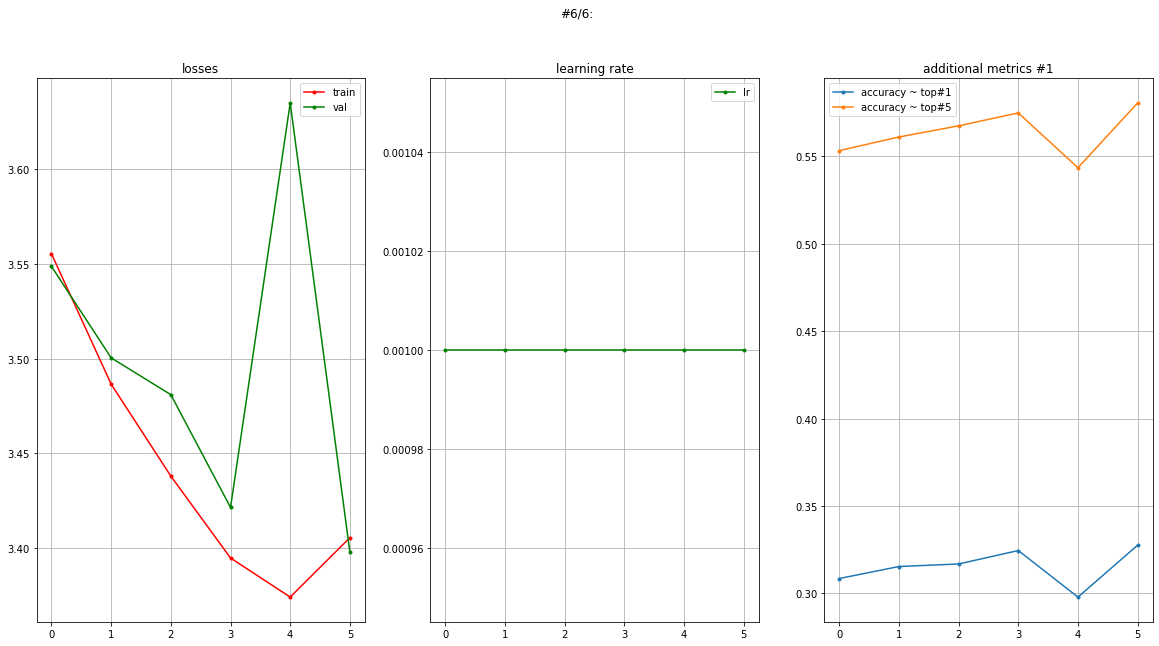

In [124]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 6,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "accuracy": {"top": [1, 5], "plot_id": 1},
    },
    chkp_folder = "./chkp",
)

In [132]:
# попробуем ручками уменьшить шаг и еще 4 эпохи обучить, чтобы лучше сойтись
for g in optimizer.param_groups:
    g['lr'] = 2.5e-4

In [133]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: [0.9, 0.999]
    eps: 1e-08
    lr: 0.00025
    maximize: False
    weight_decay: 0
)

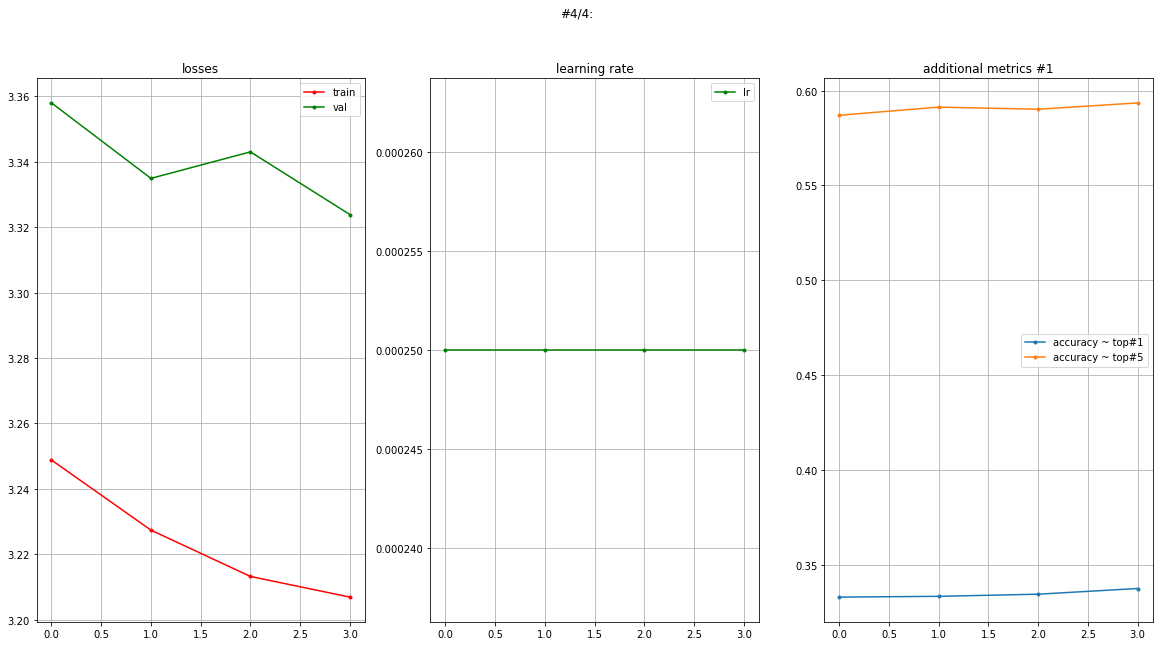

In [134]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 4,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "accuracy": {"top": [1, 5], "plot_id": 1},
    },
    chkp_folder = "./chkp",
)

In [ ]:
# медленно уже все идет, оставим пока модель так

Итого видим точность предсказания следующего слова около 0.33, а метрика top-5 где-то около 0.6. Лосс падает уже довольно медленно, а accuracy почти не меняется после 16 эпох. Таким образом, можно попробовать оценить результаты с такой моделью. В любом случае словарь большой, а модель не самая тяжелая, поэтому accuracy 0.35 вполне приемлемо

## 4. Оценка результатов

### 4.1 Генерация

In [142]:
import torch.nn.functional as F

In [201]:
#!g1.1
from typing import Optional

def generate(
    model,
    image,
    max_seq_len: Optional[int] = max_seq_len,
    top_p: Optional[float] = None,
    top_k: Optional[int] = None,
) -> str:
    """
    По картинке image генерируем текст моделью model либо пока не сгенерируете '<EOS>' токен, либо пока не сгенерируете max_seq_len токенов
        top_k -> после получения предсказания оставляете первые top_k слов и сэмплируете случайно с перенормированными вероятностями из оставшихся слов
        top_p -> после получения предсказания оставляете первые сколько-то слов, так, чтобы суммарная вероятность оставшихся слов была не больше top_p,
            после чего сэмплируете с перенормированными вероятностями из оставшихся слов
        иначе -> сэмплируете случайное слово с предсказанными вероятностями
    """
    assert top_p is None or top_k is None, "Don't use top_p and top_k at the same time"
    
    model.eval()
    filter_value=-float('Inf')
    image_prepare = tr.Compose([
                                    tr.ToPILImage(),
                                    tr.Resize((224, 224)),
                                    tr.ColorJitter(hue=.05, saturation=.05),  
                                    tr.RandomHorizontalFlip(0.5),
                                    tr.RandomRotation(20),
                                    tr.ToTensor(),
                                    tr.Normalize(channel_mean, channel_std)
                                ])
    image = image_prepare(image)
    
    with torch.no_grad():
        answ = ''
        in_seq = torch.zeros(max_seq_len) + 3
        in_seq = torch.tensor(in_seq, dtype=torch.int64)
        in_seq[-1] = 1
        for i in range(1, max_seq_len):
            logits = model(image[None,:,:,:], in_seq.unsqueeze(0), torch.tensor(1, dtype=torch.int64))
            logits = logits.squeeze(0)
                
            if top_p is not None:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                sorted_indices_to_remove = cumulative_probs > top_p
                
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[indices_to_remove] = filter_value # чтобы при перевзвешивании получались нули
                
            if top_k is not None:
                indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
                logits[indices_to_remove] = filter_value
               
            probabilities = F.softmax(logits, dim=-1) # перевзвешиваем
            next_token = torch.multinomial(probabilities, 1) # генерируем из полученного распределения
            if next_token == 2: # Если встретили EOS, то заканчиваем работу
                return answ
            
            in_seq = torch.cat([in_seq[1:], torch.tensor([next_token])])
            answ += ind_to_tok[int(next_token)] + ' '
        return answ

### 4.2 Посмотрим на предсказания модели

In [268]:
data_folder = "./data/data"

dfs = dict()
for split in ['train', 'val']:
    dfs[split] = pd.read_csv(os.path.join(data_folder, f'captions_{split}.tsv'), sep='\t')

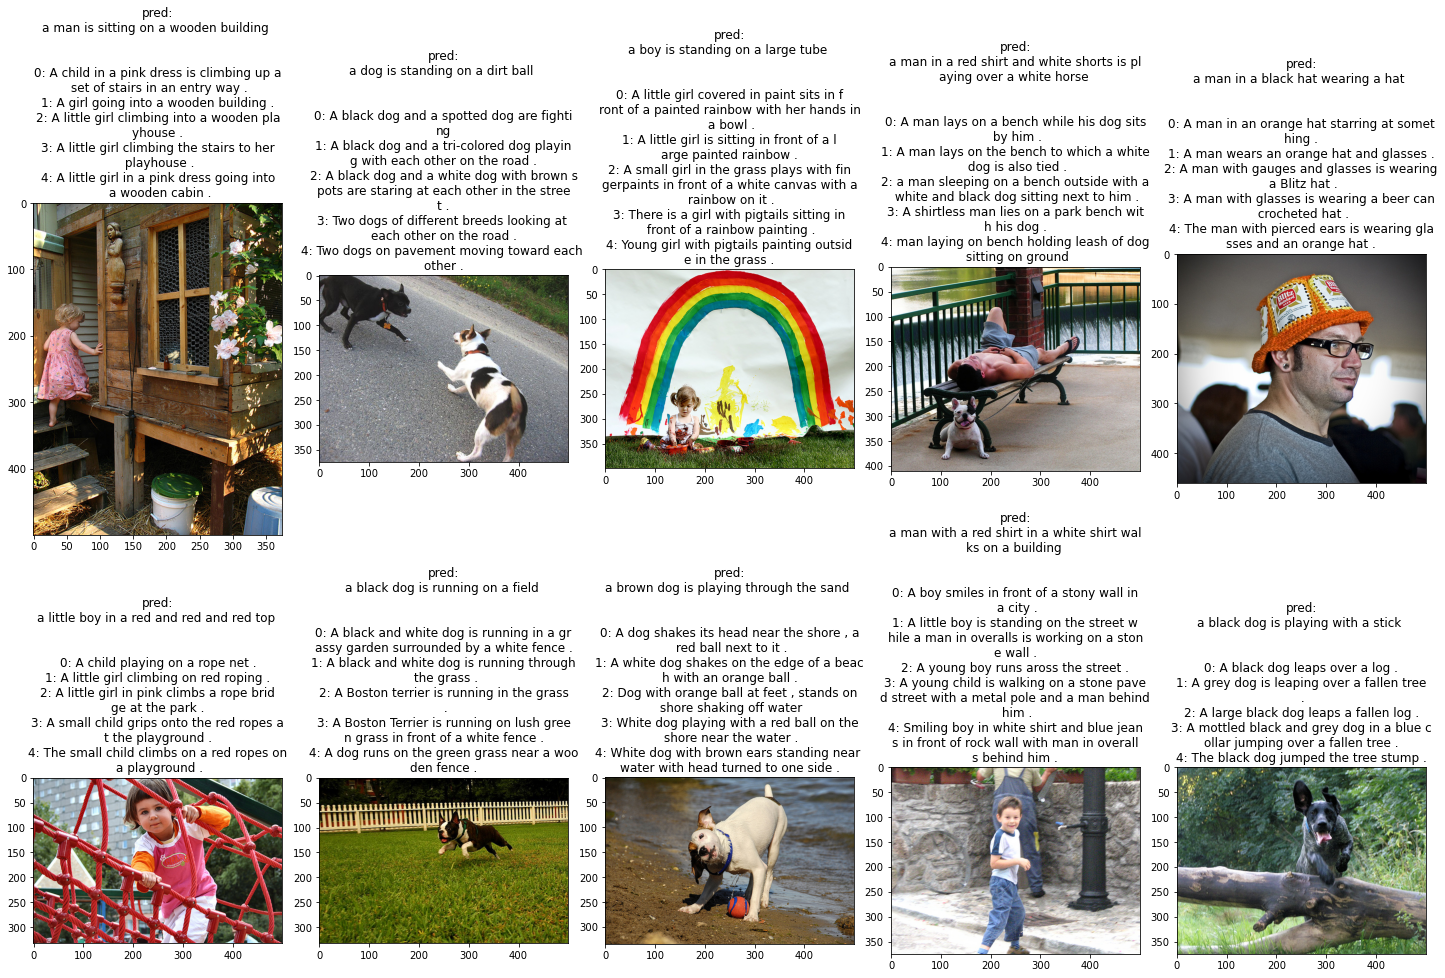

In [271]:
#!g1.1
inds = list(range(10))
split = 'train'

h, w = 2, 5
title_width = 43

assert h*w >= len(inds)

fig, ax = plt.subplots(h, w, figsize=(20, 15))

for i, ind in enumerate(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    img = cv2.imread(os.path.join(data_folder, split, img_id))
    
    pred_caption = generate(model, img, max_seq_len=max_seq_len, top_p=0.5, top_k=None)
    pred_caption = '\n'.join([pred_caption[k:k+title_width] for k in range(0, len(pred_caption), title_width)])
    
    captions = [row[f'caption #{i}'] for i in range(5)]
    caption_adjasted = list(map(lambda el: '\n'.join([(str(el[0]) + ': ' + el[1])[k:k+title_width] for k in range(0, 3 + len(el[1]), title_width)]), enumerate(captions)))
    
    caption = '\n'.join(['pred:\n' + pred_caption + '\n\n'] + caption_adjasted)
    
    plt.subplot(h, w, i+1)
    plt.title(caption)
    plt.imshow(img)

fig.tight_layout()
plt.show()

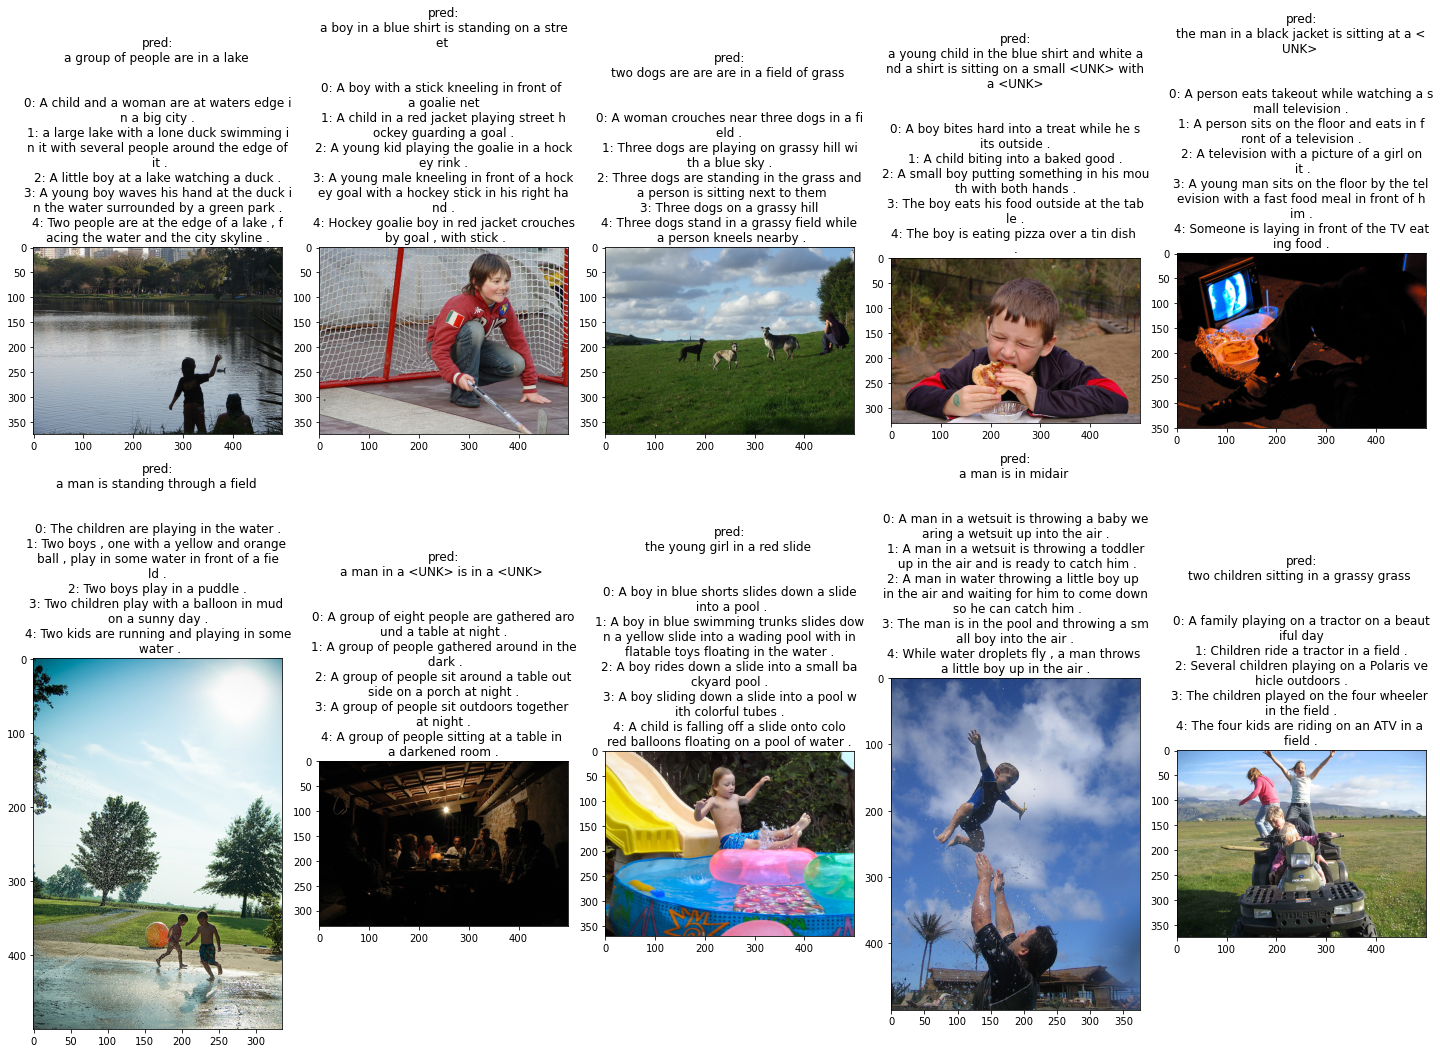

In [273]:
#!g1.1
inds = list(range(10))
split = 'val'

h, w = 2, 5
title_width = 43

top_p = None
top_k = 3

assert h*w >= len(inds)

fig, ax = plt.subplots(h, w, figsize=(20, 15))

for i, ind in enumerate(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    img = cv2.imread(os.path.join(data_folder, split, img_id))
    
    pred_caption = generate(model, img, max_seq_len=max_seq_len, top_p=None, top_k=top_k)
    pred_caption = '\n'.join([pred_caption[k:k+title_width] for k in range(0, len(pred_caption), title_width)])
    
    captions = [row[f'caption #{i}'] for i in range(5)]
    caption_adjasted = list(map(lambda el: '\n'.join([(str(el[0]) + ': ' + el[1])[k:k+title_width] for k in range(0, 3 + len(el[1]), title_width)]), enumerate(captions)))
    
    caption = '\n'.join(['pred:\n' + pred_caption + '\n\n'] + caption_adjasted)
    
    plt.subplot(h, w, i+1)
    plt.title(caption)
    plt.imshow(img)

fig.tight_layout()
plt.show()

In [ ]:
# В целом не так плохо. Как минимум релевантные слова всегда проскакивают

### 4.3 BLEU на всём val датасете

In [311]:
!pip install torchtext==0.6.0

In [312]:
import torchtext

In [320]:
from tqdm import trange

In [335]:
#!g1.1
from torchtext.data.metrics import bleu_score

def get_bleu(model, max_seq_len=max_seq_len, top_p=None, top_k=None, split="val"):
    candidates = []
    references = []
    
    inds = len(dfs[split])
    for ind in trange(inds):
        row = dfs[split].iloc[ind]
        img_id = row['img_id']
        img = cv2.imread(os.path.join(data_folder, split, img_id))
        pred_caption = generate(model, img, max_seq_len=max_seq_len, top_p=top_p, top_k=top_k)
        captions = [tokenize(row[f'caption #{i}']) for i in range(5)]
        
        candidates.append(tokenize(pred_caption))
        references.append(captions)

    return bleu_score(candidates, references)

In [336]:
#!g1.1
bleu_res = get_bleu(model, max_seq_len=max_seq_len, top_p=0.5, top_k=None, split="val")
print(bleu_res)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:22<00:00,  1.61it/s]


0.14292973279953003


In [339]:
bleu_res = get_bleu(model, max_seq_len=max_seq_len, top_p=0.3, top_k=None, split="val")
print(bleu_res)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:08<00:00,  1.64it/s]


0.17186246812343597


In [342]:
bleu_res = get_bleu(model, max_seq_len=max_seq_len, top_p=0.15, top_k=None, split="val")
print(bleu_res)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:46<00:00,  1.55it/s]


0.18244734406471252


In [343]:
bleu_res = get_bleu(model, max_seq_len=max_seq_len, top_p=0.1, top_k=None, split="val")
print(bleu_res)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:23<00:00,  1.60it/s]


0.17967383563518524


In [337]:
bleu_res = get_bleu(model, max_seq_len=max_seq_len, top_p=None, top_k=3, split="val")
print(bleu_res)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:27<00:00,  1.59it/s]


0.1335953325033188


In [341]:
bleu_res = get_bleu(model, max_seq_len=max_seq_len, top_p=None, top_k=1, split="val")
print(bleu_res)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:38<00:00,  1.57it/s]


0.17996427416801453


Чтож, лучший скор вышел при topp = 0.15: bleu = 0.182. Это, конечно, не дотягивает до порога в 0.2 совсем чуть-чуть, но ничего страшного.

In [ ]:
# Пробуем еще чуть-чуть обучить, вдруг попрог преодолеется

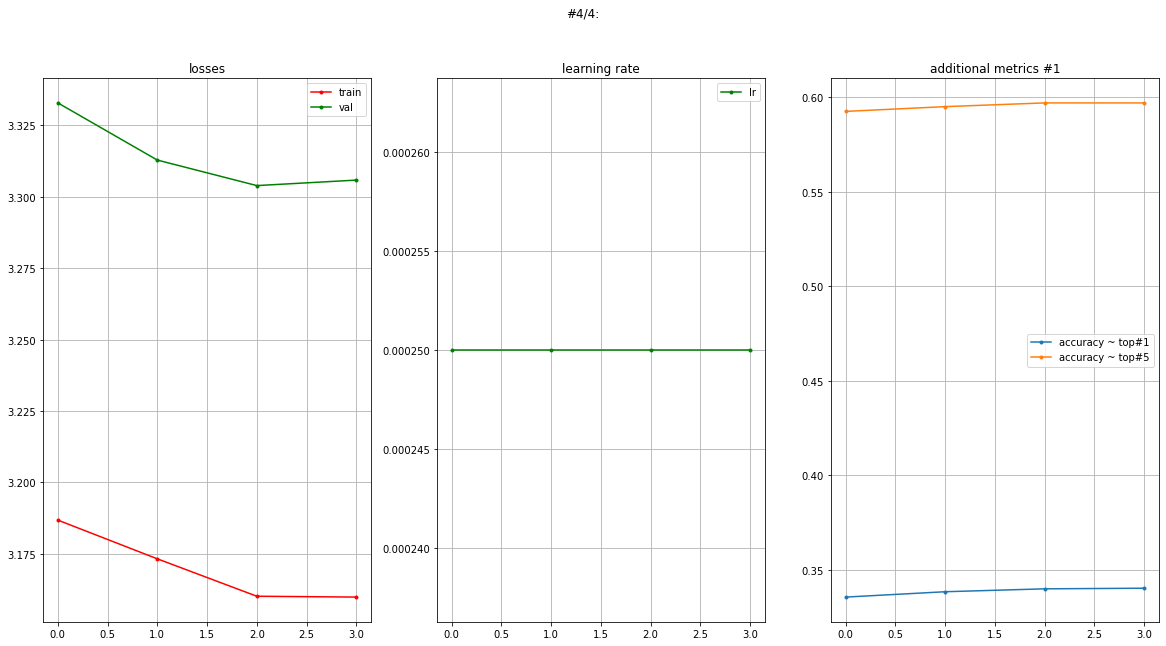

In [344]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 4,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "accuracy": {"top": [1, 5], "plot_id": 1},
    },
    chkp_folder = "./chkp",
)

In [ ]:
# Качество чуть-чуть растет все еще, но очень медленно

In [345]:
bleu_res = get_bleu(model, max_seq_len=max_seq_len, top_p=0.15, top_k=None, split="val")
print(bleu_res)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:51<00:00,  1.53it/s]


0.18139982223510742


In [346]:
bleu_res = get_bleu(model, max_seq_len=max_seq_len, top_p=None, top_k=1, split="val")
print(bleu_res)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:21<00:00,  1.61it/s]


0.18194431066513062


In [347]:
bleu_res = get_bleu(model, max_seq_len=max_seq_len, top_p=0.2, top_k=None, split="val")
print(bleu_res)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:32<00:00,  1.58it/s]


0.18349671363830566


In [ ]:
# Чтож, видно не судьба...